<a href="https://colab.research.google.com/github/Kargin-Alexey/study_projects/blob/main/bankruptcy_probability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://drive.google.com/file/d/153R-0DSRQdTDXCK--EbVQcehjyzzskpR/view?usp=sharing    
ссылка на использованные данные 

# Описание
Необходимо построить предиктивную модель, которая на основании открытых данных о судах и бухгалтерской отчетности позволит спрогнозировать вероятность банкротства компании. 
Необходимо сделать:
1.	Собрать из предложенных файлов датасет.
2.	Провести EDA, отобрать фичи и сгенерировать новые.
3.	Обучить модель.
4.	Собрать исполняемый код, который можно будет запустить на проде: на вход будет получать файлы аналогичного формата (по одному), возвращать должен прогнозное значение.

# Выгрузка файлов и формирование датасета

In [ ]:
!pip3 install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pickle
import os
from tqdm import tqdm

from sklearn.metrics import precision_score , f1_score, recall_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.preprocessing  import StandardScaler

Загрузка файлов из облака

In [ ]:
! gdown --id 153R-0DSRQdTDXCK--EbVQcehjyzzskpR

Downloading...
From: https://drive.google.com/uc?id=153R-0DSRQdTDXCK--EbVQcehjyzzskpR
To: /content/Sample_Task.zip
8.38MB [00:00, 132MB/s]


Распаковка зип файла и чтение датасетов

In [ ]:
! unzip /content/Sample_Task.zip

Archive:  /content/Sample_Task.zip
replace court_cases_sample.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace df_accounts_sample.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace df_bankruptcies_sample.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Описание задачи.docx? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
accounts_sample = pd.read_csv('/content/df_accounts_sample.csv',index_col=0)
bankruptcies_sample = pd.read_csv('/content/df_bankruptcies_sample.csv',index_col=0)

In [ ]:
! unzip /content/court_cases_sample.zip

Archive:  /content/court_cases_sample.zip
replace success/7736609147_b.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
accounts_sample.head()

,inn,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,okei
0,2465002653,2012,0.0,113756,122240,384
1,3505003270,2012,21461.0,20211,81132,384
2,3517003250,2012,0.0,0,48063,384
3,5501078737,2012,0.0,288763,419522,384
4,6140019517,2012,0.0,0,11089,384


Значения признаков по столбцам в ***accounts_sample***:    
***inn***- инн компании    
***year*** - год, в котором собраны данные     
***long_term_liabilities_fiscal_year***- долгосрочные обязатесльва компании в рассматриваемом году    
***short_term_liabilities_fiscal_year*** - краткосрочные обязатесльва компании в рассматриваемом году    
***balance_assets_fiscal_year*** - сумма активов компании    
***okei*** - отвечает за единицу измерения `{383:'рубль', 384:'тысяча рублей', 385:'миллион рублей'}`

In [ ]:
bankruptcies_sample.head()

,bankrupt_id,bancrupt_year,inn
0,79546,2015,5620006322
1,76594,2015,2111008200
2,94301,2016,5414100369
3,93799,2019,2347009476
4,199671,2018,7224008489


Значения признаков по столбцам в ***bankruptcies_sample***:    
***inn*** - инн компании, оформляющей банкротство   
***bancrupt_year*** - год, в котором было оформлено банкротство     
***bankrupt_id*** - id банкротства    


In [ ]:
os.listdir('/content')

['.config',
 'court_cases_sample.zip',
 'Описание задачи.docx',
 'success',
 'catboost_info',
 'Sample_Task.zip',
 'bankruptcies_model.sav',
 '__MACOSX',
 'court_cases.pkl',
 'df_accounts_sample.csv',
 'df_bankruptcies_sample.csv',
 'sample_data']

In [ ]:
court_cases = pd.DataFrame(None)
date_list=[]
for pkl_file in tqdm(os.listdir('/content/success')):
  try:
    for case in pd.read_pickle(open('success/'+pkl_file,'rb'))['cases_list']:
      court_cases = court_cases.append(case['case_sides'])
      date_list.append([case['caseDate']]*len(case['case_sides']))
  except:
    print('success/'+pkl_file)

 12%|█▏        | 24/194 [00:06<00:35,  4.74it/s]

success/.DS_Store


100%|██████████| 194/194 [01:19<00:00,  2.45it/s]


In [ ]:
all_date_list=[]
for date_duplicate in date_list:
  for date in date_duplicate:
    all_date_list.append(date)

In [ ]:
court_cases['date'] = pd.to_datetime(all_date_list).year

In [ ]:
court_cases['type'].unique()

array([0, 1, 3, 2])

***court_cases*** - таблица с информацией о судебных делах, в которых принимал участие компания.   
Значения признаков по столбцам в ***court_cases***:    
***type*** - в качествте кого компания принимала участие в суде, значения `{0:'истец', 1:'ответчик', 2:'свидетель'}`    
***INN*** - инн компании    
Остальные столбцы не представляют для нас интерес.

Сформируем признак ***assets_liabilities_ratio*** - отношение всех обязательств к активам компании в таблице ***accounts_sample***.     
Из таблице ***bankruptcies_sample*** определим есть ли компании, несколько раз оформлявшие банкротство.         
Из таблицы ***court_cases*** определим сколько раз компании участвовали в судебных заседаниях в роли ответчика


In [ ]:
court_cases.columns = court_cases.columns.str.lower()

In [ ]:
court_cases_pivot = court_cases.query('type==1').pivot_table(index = 'inn',
                        columns='date',
                        values='type',
                        aggfunc='count').fillna(0)
court_cases_pivot.describe()

date,1991,1992,1993,1995,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
count,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.00000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.00000,2256.000000
mean,0.000443,0.000887,0.000887,0.000443,0.000443,0.003103,0.003546,0.001773,0.008422,0.008422,0.003989,0.007979,0.028812,0.062500,0.08422,0.136082,0.205674,0.262855,0.256206,0.431294,0.413121,0.441046,0.470301,0.415780,0.363475,0.367021,0.309397,0.20789,0.074468
std,0.021054,0.029768,0.042108,0.021054,0.021054,0.081500,0.098709,0.051552,0.225670,0.319950,0.105217,0.165622,0.516309,0.905805,1.00729,1.514047,2.022552,1.899834,1.534801,4.028686,2.746412,2.575697,3.025392,2.282683,2.181961,2.807505,2.448226,1.78134,0.778164
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,1.000000,1.000000,2.000000,1.000000,1.000000,3.000000,4.000000,2.000000,10.000000,15.000000,4.000000,6.000000,18.000000,39.000000,38.00000,59.000000,72.000000,58.000000,43.000000,139.000000,106.000000,76.000000,117.000000,81.000000,53.000000,94.000000,64.000000,49.00000,28.000000


In [ ]:
accounts_sample['assets_liabilities_ratio'] = (accounts_sample[['long_term_liabilities_fiscal_year',
                                                               'short_term_liabilities_fiscal_year']].sum(axis=1) / accounts_sample['balance_assets_fiscal_year'])

accounts_sample['assets_liabilities_ratio'].replace(np.inf,10**3,inplace=True)

In [ ]:
accounts_sample['assets_liabilities_ratio'].describe()

count      1028.000000
mean        274.922346
std        5753.179629
min           0.000000
25%           0.323001
50%           0.792224
75%           1.156356
max      130481.363636
Name: assets_liabilities_ratio, dtype: float64

In [ ]:
assets_liabilities_ratio = accounts_sample.pivot_table(index='inn',
                            columns='year',
                            values='assets_liabilities_ratio',
                            aggfunc='mean')
assets_liabilities_ratio.head()

year,2012,2013,2014,2015,2016,2017,2018,2019,2020
inn,,,,,,,,,
1001003743,0.24551,0.245510,0.047021,0.042968,0.181837,0.883768,0.969523,1.101781,NaN
1020010136,NaN,NaN,NaN,1.130107,1.292272,2.488320,3.790321,NaN,NaN
1203000142,NaN,NaN,NaN,NaN,NaN,0.847180,0.842024,0.856571,0.830883
1302000640,0.00000,0.998804,0.998804,NaN,NaN,NaN,NaN,NaN,NaN
1411004211,0.00000,0.742093,0.704154,0.684849,0.693911,NaN,NaN,NaN,NaN


Создадим признаки ***last_ratio*** и ***mean_ratio*** показывающие задолжности за последний год и задолжности в среднем.

In [ ]:
assets_liabilities_ratio['last_ratio'] = assets_liabilities_ratio.apply( lambda row:np.array(row.dropna())[-1], axis=1)
assets_liabilities_ratio['mean_ratio'] = assets_liabilities_ratio.drop('last_ratio',axis=1).mean(axis=1)
assets_liabilities_ratio.head()

year,2012,2013,2014,2015,2016,2017,2018,2019,2020,last_ratio,mean_ratio
inn,,,,,,,,,,,
1001003743,0.24551,0.245510,0.047021,0.042968,0.181837,0.883768,0.969523,1.101781,NaN,1.101781,0.464740
1020010136,NaN,NaN,NaN,1.130107,1.292272,2.488320,3.790321,NaN,NaN,3.790321,2.175255
1203000142,NaN,NaN,NaN,NaN,NaN,0.847180,0.842024,0.856571,0.830883,0.830883,0.844165
1302000640,0.00000,0.998804,0.998804,NaN,NaN,NaN,NaN,NaN,NaN,0.998804,0.665869
1411004211,0.00000,0.742093,0.704154,0.684849,0.693911,NaN,NaN,NaN,NaN,0.693911,0.565001


In [ ]:
bankruptcies_sample.inn.nunique() == bankruptcies_sample.inn.shape[0]

True

В данных о судах присутвуют 4 тип участия в процессе. Сказать о нём что-то не представляется возможным.    
Из данных видно, что более 75% крмпании никогда не были в суде в качестве ответчика, более 50% никогда не подавали на кого-либо в суд.

Из известных данных, ни одна компания не оформляла банкротство больше 1 раза.


## Исследовательский анализ данных
Составим один датасет.
Предварительно установим везде в индекс инн.

In [ ]:
normal_index=[]
invalid_index=[]
for inn in court_cases_pivot.index:
  inn_join = ''.join(inn.split(' '))
  try:
    normal_index.append(int(inn_join[:10]))
  except:
    invalid_index.append(inn)
    print(inn_join)


*


In [ ]:
court_cases_pivot.drop(invalid_index,inplace=True)

In [ ]:
bankruptcies_sample.set_index('inn', inplace=True)
court_cases_pivot.index = normal_index

In [ ]:
data = assets_liabilities_ratio[['last_ratio','mean_ratio']].join(bankruptcies_sample)
data.bancrupt_year.unique()

array([  nan, 2018., 2020., 2015., 2017., 2013., 2019., 2021., 2014.,
       2012., 2011., 2016.])

Так как самое раннене банкротсво в представленных данных - 2011 год, то оставим данные о судах с 2009 года.

In [ ]:
data = data.join(court_cases_pivot.loc[:,'2009':])
data.columns = data.columns.astype('str')

In [ ]:
data.head()

,last_ratio,mean_ratio,bankrupt_id,bancrupt_year,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
1001003743,1.101781,0.464740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1020010136,3.790321,2.175255,176347.0,2018.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,20.0,28.0,1.0,1.0,0.0
1203000142,0.830883,0.844165,380484.0,2020.0,4.0,11.0,15.0,17.0,1.0,1.0,5.0,17.0,16.0,22.0,49.0,20.0,2.0
1302000640,0.998804,0.665869,76122.0,2015.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
1411004211,0.693911,0.565001,154559.0,2017.0,1.0,0.0,0.0,0.0,1.0,4.0,4.0,1.0,2.0,2.0,0.0,0.0,0.0


оставим в признаках только сумму по судебным делам за последние 3 года, если было банкротсво то  за последние 3 года до банкротства. Данные по годам удалим

In [ ]:
def courts(row):
  try:
    year = row['bancrupt_year']
    sum = row[str(int(year-2)) : str(int(year+1))].sum()
    return sum

  except:
    return 0 

data['courts'] = data.apply(courts,axis=1)

In [ ]:
data.head()

,last_ratio,mean_ratio,bancrupt_year,courts,bankrupt
1001003743,1.101781,0.464740,NaN,0,0.0
1020010136,3.790321,2.175255,2018.0,0,1.0
1203000142,0.830883,0.844165,2020.0,0,1.0
1302000640,0.998804,0.665869,2015.0,0,1.0
1411004211,0.693911,0.565001,2017.0,0,1.0


In [ ]:
data.columns

Index(['last_ratio', 'mean_ratio', 'bancrupt_year', 'courts', 'bankrupt'], dtype='object')

In [ ]:
data=data[['last_ratio', 'mean_ratio', 'bancrupt_year','courts']]

Создадим столбец ***bankrupt***, отражающий было ли банкротство компании

In [ ]:
data.loc[data['bancrupt_year']>0,'bankrupt'] = 1
data['bankrupt'].fillna(0,inplace=True)

In [ ]:
data.head()

,last_ratio,mean_ratio,bancrupt_year,courts,bankrupt
1001003743,1.101781,0.464740,NaN,0,0.0
1020010136,3.790321,2.175255,2018.0,0,1.0
1203000142,0.830883,0.844165,2020.0,0,1.0
1302000640,0.998804,0.665869,2015.0,0,1.0
1411004211,0.693911,0.565001,2017.0,0,1.0


Изучим данные

In [ ]:
data.describe()

,last_ratio,mean_ratio,bancrupt_year,courts,bankrupt
count,167.000000,167.000000,107.000000,167.0,167.000000
mean,87.590106,111.596607,2016.738318,0.0,0.640719
std,267.768084,1131.423764,3.022983,0.0,0.481233
min,0.000000,0.000000,2011.000000,0.0,0.000000
25%,0.322056,0.435010,2014.000000,0.0,0.000000
50%,0.992447,0.849274,2017.000000,0.0,1.000000
75%,2.875153,2.214072,2019.000000,0.0,1.000000
max,1000.000000,14609.646442,2021.000000,0.0,1.000000


В представленных данных более половины компаний обанкротилась (64%), из них как минимум половина за последние 4 года. Также для половины компаний справедливо утверждение, что за последний год они имели обязательств больше или примерно столько же, сколько автивов. Половина компаний имела 3 и более судебных исков.    

Посмотрим, как коррелируют величины


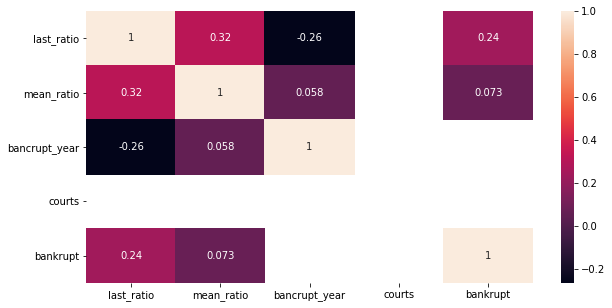

In [ ]:
plt.figure(figsize=(10,5))
sb.heatmap(data.corr(), annot=True)

Из корреляций видно, что количество судебных исков за последние 3 года сильно коррелирует с фактом банкротства. Также банкротство на 24% коррелирует с соотношением обязательств к активам.    
Помотрим их рапределения относительно друг друга.

Распредеение количества судебных исков на компанию в 2018 относительно факта банкротсва

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


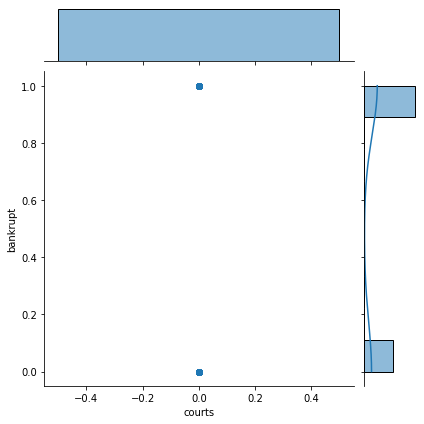

In [ ]:
sb.jointplot(data=data, x='courts', y="bankrupt", kind="reg")

Распредеение соотношения обязательств к долгам компании относительно факта банкротсва

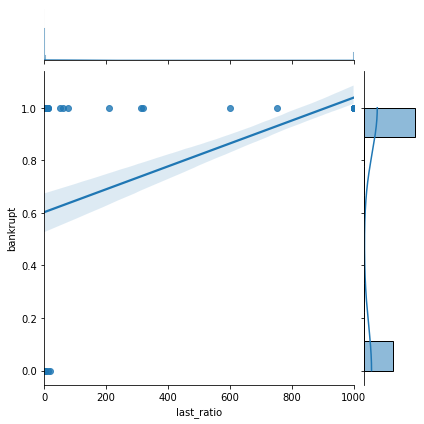

In [ ]:
sb.jointplot(data=data, x="last_ratio", y="bankrupt", kind="reg")

Из рапределений видно: если обязательства сильно превышают активы, то вероятнее всего, что такая компания - банкрот.    
Аналогичное утверждение справедливо для судебных исков. Чем больше исков, тем ненадежнее компания.

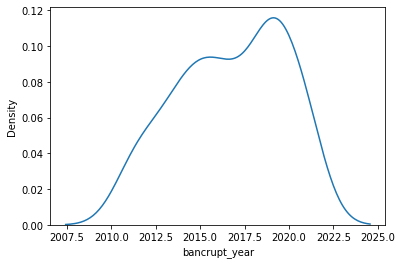

In [ ]:
sb.kdeplot(data.bancrupt_year)

В 2020 видно всплеск банкротств, что скорее всего вызвано пандемией ковида

## Обучение модели
Обучеим модели, решающие задачу классификации.
Метриками качества будут f1 и accuracy. Дополнительно вычислим полноту для классов, чтобы определить сколько процентов компаний-банкротов мы теоретически можем выявлять.

In [ ]:
features = data.drop(['bancrupt_year','bankrupt'],axis=1)
target = data['bankrupt']

Разлбьём данные на тренировочную и валидационную выборки в соотношениях 70 на 30.

In [ ]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.3, random_state=12345
)

In [ ]:
log_model = LogisticRegression()
log_model.fit(features_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Метрики

In [ ]:
def negative_recall(target,predict):
  plus = target + predict
  minus = predict - target 
  TN = (plus == 0).sum()
  FP = (minus == 1).sum()
  return FP / (FP + TN)

In [ ]:
print('f1=',f1_score(target_valid, log_model.predict(features_valid)))
print('accuracy=', accuracy_score(target_valid, log_model.predict(features_valid)))
print('negative_recall=', negative_recall(target_valid, log_model.predict(features_valid)))
print('recall=',recall_score(target_valid, log_model.predict(features_valid)))

f1= 0.8
accuracy= 0.6666666666666666
negative_recall= 1.0
recall= 1.0


Посмотрим, как изменится модель при нормализации количества судебных исков.

In [ ]:
features_norm = features.copy()
features_norm =  np.log(features_norm+1) #добавим единицу так как в выборке есть нули

In [ ]:
features_train_norm, features_valid_norm, target_train_norm, target_valid_norm = train_test_split(
    features_norm, target, test_size=0.3, random_state=12345
)

In [ ]:
log_model_norm = LogisticRegression()
log_model_norm.fit(features_train_norm, target_train_norm)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
print('f1=',f1_score(target_valid_norm, log_model_norm.predict(features_valid_norm)))
print('accuracy=', accuracy_score(target_valid_norm, log_model_norm.predict(features_valid_norm)))
print('negative_recall=', negative_recall(target_valid_norm, log_model_norm.predict(features_valid_norm)))
print('recall=',recall_score(target_valid_norm, log_model_norm.predict(features_valid_norm)))

f1= 0.8378378378378379
accuracy= 0.7647058823529411
negative_recall= 0.5294117647058824
recall= 0.9117647058823529


Модель с нормализацией не показала преимуществ.    
Модели не прогнозируют клиентам ложное банкротство, но пропускает почти 18% банкротов.        
Вычислим процент вычесленных обанкротившихся компаний и процент упущенных клиентов. Рассмотрим разные вероятности банкротства. 

In [ ]:
target.mean()

0.6407185628742516

In [ ]:
probas=np.array([[0.1,0.9],
                 [0.3,0.7],
                 [0.4,0.6],
                 [0.5,0.5],
                 [0.6,0.4],
                 [0.7,0.3],
                 [0.9,0.1]])
recall=0.823529
recall_neg=0

print(probas[:,1]  * recall / (probas[:,1]  * recall  + probas[:,0]  * (1-recall) ) )
print(probas[:,0]  * recall_neg / (probas[:,0]  * recall_neg  + probas[:,1]  * (1-recall_neg) ) )

[0.97674412 0.91588763 0.87499969 0.823529   0.75675624 0.66666604
 0.34146278]
[0. 0. 0. 0. 0. 0. 0.]


 в нашей выборке 64% компаний - банкротов. При вероятностях банкротства свыше 40% моделью будет выявляться более 75.7% от всех банкротов, при вероятности банкротсв от 70% будет выявляться до 91% всех банкротов. Во всех случаях ни один не банкрот не был ложно отмечен.

Проверим какое качество показывает модель градиентного бустинга CatBoost

In [ ]:
cat_model = CatBoostClassifier(verbose=500)
cat_model.fit(features_train, target_train)

print('f1=',f1_score(target_valid, cat_model.predict(features_valid)))
print('accuracy=', accuracy_score(target_valid, cat_model.predict(features_valid)))
print('negative_recall=', negative_recall(target_valid, cat_model.predict(features_valid)))
print('recall=',recall_score(target_valid, cat_model.predict(features_valid)))

Learning rate set to 0.004106
0:	learn: 0.6919757	total: 581us	remaining: 581ms
500:	learn: 0.4478202	total: 313ms	remaining: 311ms
999:	learn: 0.3679573	total: 616ms	remaining: 0us
f1= 0.735294117647059
accuracy= 0.6470588235294118
negative_recall= 0.5294117647058824
recall= 0.7352941176470589


In [ ]:
cat_model_norm = CatBoostClassifier(verbose=200)
cat_model_norm.fit(features_train_norm, target_train_norm)

print('f1=',f1_score(target_valid_norm, cat_model_norm.predict(features_valid_norm)))
print('accuracy=', accuracy_score(target_valid_norm, cat_model_norm.predict(features_valid_norm)))
print('negative_recall=', negative_recall(target_valid_norm, cat_model_norm.predict(features_valid_norm)))
print('recall=',recall_score(target_valid_norm, cat_model_norm.predict(features_valid_norm)))

Learning rate set to 0.004106
0:	learn: 0.6919757	total: 583us	remaining: 583ms
200:	learn: 0.5331103	total: 133ms	remaining: 531ms
400:	learn: 0.4701124	total: 256ms	remaining: 382ms
600:	learn: 0.4300489	total: 373ms	remaining: 247ms
800:	learn: 0.3979530	total: 502ms	remaining: 125ms
999:	learn: 0.3679573	total: 651ms	remaining: 0us
f1= 0.735294117647059
accuracy= 0.6470588235294118
negative_recall= 0.5294117647058824
recall= 0.7352941176470589


Модель градиентного CatBoost не выдает качества лучше, чем Логистическая регрессия. Так как данных не много оценки качества могут быть неточными. 
На данном этапе оптимальнее использовать логистическую регрессию.

## Выводы
Для создания модели, предсказывающей вероятность банкротство компании были предоставлены данные по активам и обязательствам 167 компании в разные годы, из них 64% обанкротились, более половины за последние 4 года. Также были предоставлены данные о 2256 исках на компании начиная с 1991 года.     

Было выявлено, что количество судебных исков на компанию за последние 3 года сильно коррелирует с фактом банкротства (на 46%). Также банкротство на 24% коррелирует с соотношением обязательств к активам за последний финансовый год.    

В результате была построена модель, учитывающая соотношение активов к обязательствам за последний финансовый год и среднее за всё время существования компании.    
Качество модели по метрике f1 составило 90.32%. Точность модели (accuracy) 88.23%. При этом модель не прогнозируют клиентам ложное банкротство. 
В зависимости от общего процента банкроства, количество пропущенных компаний банкротов может варьироваться:
- Менее 10% при вероятности банкротсв 70%
- Около 34% при вероятности банкротств 30%